We will be fine-tuning a pretrained Data-efficient Image Transformer (DeiT) model available. We will apply the Projected Gradient Descent (PGD) attack.

https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/hugging_face_evasion.ipynb

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers

from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.defences.trainer import AdversarialTrainerMadryPGD
from art.utils import load_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
(x_train, y_train), (_,_), _,_ = load_dataset("cifar10")

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
y_train = np.argmax(y_train, axis=1)

classes = np.unique(y_train)
samples_per_class = 100

x_subset=[]
y_subset=[]

for c in classes:
    indices = y_train == c
    x_subset.append(x_train[indices][:samples_per_class])
    y_subset.append(y_train[indices][:samples_per_class])

x_subset = np.concatenate(x_subset)
y_subset = np.concatenate(y_subset)

print(f'x_subset:', x_subset.dtype, x_subset.shape)
print(f'y_subset:', y_subset.dtype, y_subset.shape)

x_subset: float32 (1000, 3, 32, 32)
y_subset: int64 (1000,)


In [3]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [4]:
if not os.path.isdir('./state_dicts'):
    os.mkdir('./state_dicts')

In [5]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    'facebook/deit-tiny-distilled-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=10
)
model

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassificationWithTeacher(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
           

In [6]:
type(model)

transformers.models.deit.modeling_deit.DeiTForImageClassificationWithTeacher

Frequently we will be performing fine-tuning or transfer learning with vision transformers and so we may be fine-tuning on differently sized inputs.m
+ The input_shape arguments refers to the shape of the supplied input data which may be different to the shape required by the model
     - To handle this HuggingFaceClassifierPyTorch has an extra argument of processor which will act on.
+ Here the processor is a simple upsampler to enlarge the cifar images into the right size

In [7]:
upsampler = torch.nn.Upsample(scale_factor=7, mode="nearest")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
hf_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape =(3,32,32),
    nb_classes=10,
    clip_values=(0,1),
    processor=upsampler
)

In [8]:
# load saved model if it already exists, otherwise train it

model_checkpoint_path = './state_dicts/deit_cifar_base_model.pt'
if os.path.isfile(model_checkpoint_path):
    hf_model.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    hf_model.fit(x_subset, y_subset, nb_epochs=5)
    torch.save(hf_model.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

loaded model checkpoint


C:\Users\Usuario\AppData\Local\Temp\ipykernel_15344\1523934489.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hf_model.model.load_state_dict(torch.load(model_checkpoint

In [9]:
outputs = hf_model.predict(x_subset)
clean_preds = np.argmax(outputs, axis=1)
clean_acc = np.mean(clean_preds == y_subset)
print('clean accuracy:', clean_acc)

C:\Users\Usuario\Anaconda3\envs\redai\Lib\site-packages\transformers\models\deit\modeling_deit.py:208: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


clean accuracy: 0.908


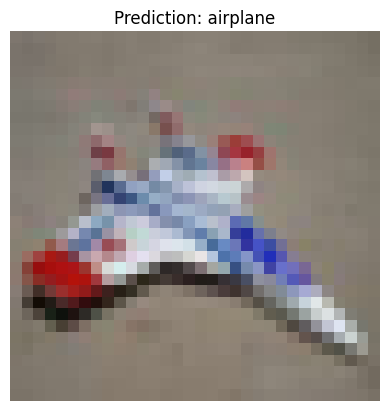

In [10]:
plt.imshow(np.transpose(x_subset[1], (1, 2, 0)))
plt.title(f'Prediction: {label_names[clean_preds[1]]}')
plt.axis('off')
plt.show()

At this point we have our target model trained

## adversarial attack / evasion

In [11]:
adv_samples_path = './state_dicts/x_adv_base.npy'
if os.path.isfile(adv_samples_path):
    x_adv = np.load(adv_samples_path)
else:
    attacker = ProjectedGradientDescentPyTorch(hf_model, eps=8/255, eps_step=1/255)
    x_adv = attacker.generate(x_subset)
    np.save(adv_samples_path, x_adv)

outputs = hf_model.predict(x_adv)
adv_preds = np.argmax(outputs, axis=1)
adv_acc = np.mean(adv_preds == y_subset)
print('adversarial accuracy:', adv_acc)

adversarial accuracy: 0.024


In [12]:
len(np.argmax(outputs, axis=1))

1000

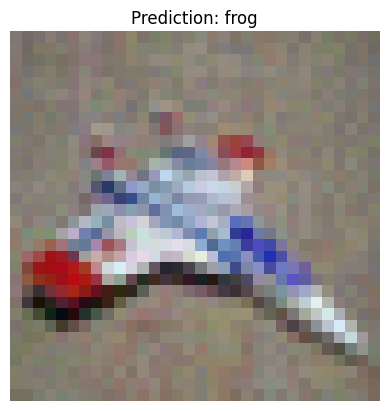

In [13]:
plt.imshow(np.transpose(x_adv[1], (1, 2, 0)))
plt.title(f'Prediction: {label_names[adv_preds[1]]}')
plt.axis('off')
plt.show()

lets display the adversarial examples to highlight the added perturbation to the original sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6077032e-07..0.62745106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6077032e-07..0.62745106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6077032e-07..0.62745106].


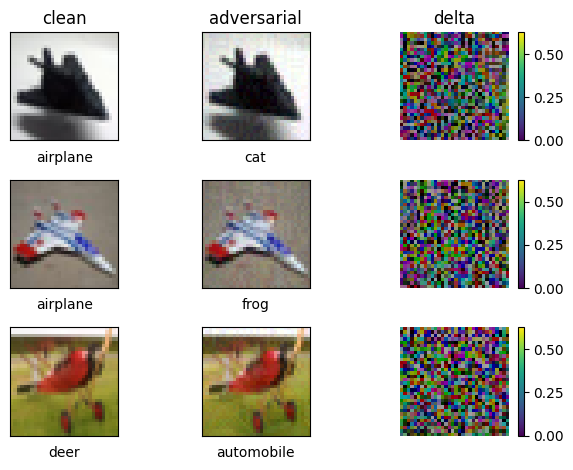

In [17]:
delta = ((x_subset - x_adv) + 8/255) * 10

fig, axs = plt.subplots(3, 3)
for i in range(3):
    axs[i, 0].imshow(np.transpose(x_subset[i], (1, 2, 0)))
    axs[i, 0].set_xlabel(label_names[clean_preds[i]])
    axs[i, 0].tick_params(axis='both', which='both',length=0)
    axs[i, 0].axes.xaxis.set_ticklabels([])
    axs[i, 0].axes.yaxis.set_ticklabels([])
    axs[i, 1].imshow(np.transpose(x_adv[i], (1, 2, 0)))
    axs[i, 1].axes.xaxis.set_ticklabels([])
    axs[i, 1].axes.yaxis.set_ticklabels([])
    axs[i, 1].tick_params(axis='both', which='both',length=0)
    axs[i, 1].set_xlabel(label_names[adv_preds[i]])
    im = axs[i, 2].imshow(np.transpose(delta[i], (1, 2, 0)))
    axs[i, 2].axis('off')
    fig.colorbar(im)
axs[0, 0].set_title('clean')
axs[0, 1].set_title('adversarial')
axs[0, 2].set_title('delta')
plt.tight_layout()

lets save the adversarial output as png file.

In [63]:
x_adv[1].shape

(3, 32, 32)

In [44]:
np.transpose(x_adv[1], (1, 2, 0)).shape

(32, 32, 3)

In [68]:
import matplotlib.image

matplotlib.image.imsave('name.png', np.transpose(x_adv[1], (1, 2, 0)))

In [76]:
assessment_img = Image.open('name.png')
 
# summarize some details about the image
print(assessment_img.format)
print(assessment_img.size)
print(assessment_img.mode)

PNG
(32, 32)
RGBA


In [77]:
assessment_img = assessment_img.convert("RGB")
assessment_img = np.array(assessment_img)
assessment_img = assessment_img.transpose(2, 0, 1)

In [78]:
print(assessment_img.shape)
print(x_adv[1].shape)

(3, 32, 32)
(3, 32, 32)


In [83]:
np.expand_dims(assessment_img, axis=0).shape

(1, 3, 32, 32)

In [95]:
outputs

array([[-0.06302121, -0.38051957, -0.10291496, -0.43372926,  1.575228  ,
        -1.2443254 ,  1.1026785 ,  0.7535002 ,  0.48075587, -0.43811944]],
      dtype=float32)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15344\3119859206.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Prediction: {label_names[int(adv_preds_one)]}')


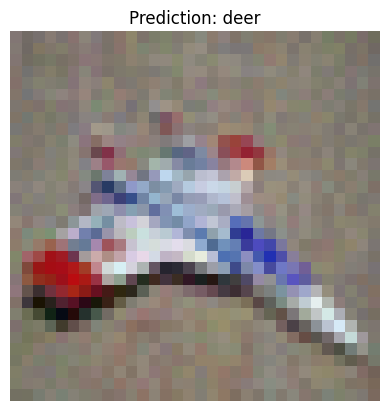

In [94]:
outputs = hf_model.predict(np.expand_dims(assessment_img, axis=0))
adv_preds_one = np.argmax(outputs, axis=1)
plt.imshow(np.transpose(assessment_img, (1, 2, 0)))
plt.title(f'Prediction: {label_names[int(adv_preds_one)]}')
plt.axis('off')
plt.show()

## Adversarial training with ART

In [96]:
?AdversarialTrainerMadryPGD

Init signature:
AdversarialTrainerMadryPGD(
    classifier: "'CLASSIFIER_LOSS_GRADIENTS_TYPE'",
    nb_epochs: 'int | None' = 205,
    batch_size: 'int | None' = 128,
    eps: 'int | float' = 8,
    eps_step: 'int | float' = 2,
    max_iter: 'int' = 7,
    num_random_init: 'int' = 1,
) -> 'None'
Docstring:     
Class performing adversarial training following Madry's Protocol.

| Paper link: https://arxiv.org/abs/1706.06083

| Please keep in mind the limitations of defences. While adversarial training is widely regarded as a promising,
    principled approach to making classifiers more robust (see https://arxiv.org/abs/1802.00420), very careful
    evaluations are required to assess its effectiveness case by case (see https://arxiv.org/abs/1902.06705).
Init docstring:
Create an :class:`.AdversarialTrainerMadryPGD` instance.

Default values are for CIFAR-10 in pixel range 0-255.

:param classifier: Classifier to train adversarially.
:param nb_epochs: Number of training epochs.
:param bat

In [97]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    'facebook/deit-tiny-distilled-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=10
)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

hf_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0, 1),
    processor=upsampler
)

trainer = AdversarialTrainerMadryPGD(
    classifier=hf_model,
    nb_epochs=10,
    eps=8/255,
    eps_step=1/255,
    max_iter=10
)

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [98]:
# load saved model if it already exists, otherwise train it

model_checkpoint_path = './state_dicts/deit_cifar_robust_model.pt'
if os.path.isfile(model_checkpoint_path):
    trainer.classifier.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    trainer.fit(x_subset, y_subset, nb_epochs=5)
    torch.save(trainer.classifier.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

saved model checkpoint


In [99]:
outputs = trainer.classifier.predict(x_subset)
clean_preds = np.argmax(outputs, axis=1)
clean_acc = np.mean(clean_preds == y_subset)
print('clean accuracy:', clean_acc)

clean accuracy: 0.101


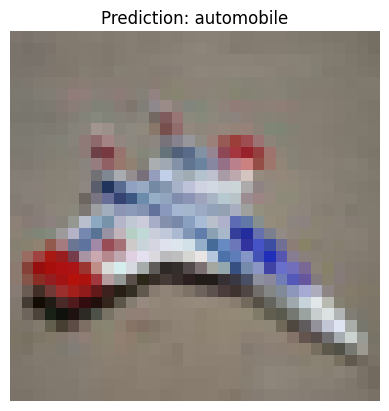

In [100]:
plt.imshow(np.transpose(x_subset[1], (1, 2, 0)))
plt.title(f'Prediction: {label_names[clean_preds[1]]}')
plt.axis('off')
plt.show()

In [101]:
# load adversarial samples if they already exist, otherwise generate them

adv_samples_path = './state_dicts/x_adv_robust.npy'
if os.path.isfile(adv_samples_path):
    x_adv = np.load(adv_samples_path)
else:
    attacker = ProjectedGradientDescentPyTorch(trainer.classifier, eps=8/255, eps_step=1/255)
    x_adv = attacker.generate(x_subset)
    np.save(adv_samples_path, x_adv)

outputs = trainer.classifier.predict(x_adv)
adv_preds = np.argmax(outputs, axis=1)
adv_acc = np.mean(adv_preds == y_subset)
print('adversarial accuracy:', adv_acc)

PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

adversarial accuracy: 0.102
